### Prepare the notebook to have access to all files

In [1]:
import os
import sys
# get the project root
__filename__ = os.path.abspath("..")
__dirname__ = os.path.dirname(__filename__)
if __dirname__ not in sys.path:
    sys.path.append(__dirname__)

### Visualization and process library

In [2]:
import re
import numpy as np
import matplotlib.pyplot as plt

import random

from tqdm import notebook
tqdmn = notebook.tqdm

### Debugging Tool

In [3]:
from importlib import reload

# Data Loading

In [ ]:
from library.data_loader import get_train_datasets

In [9]:
data = {
    "data_en_de": None,
    "data_en_fr": None,
    "data_en_tl": None,
}

In [10]:
for key in data.keys():
    data[key] = get_train_datasets(key)

In [11]:
all_data = { "query": [], "documents": [], "relevance": [] }

In [12]:
for key in data.keys():
    all_data["query"] = all_data["query"] + data[key]["query"]
    all_data["documents"] = all_data["documents"] + data[key]["documents"]
    all_data["relevance"] = all_data["relevance"] + data[key]["relevance"]

# Model Libraries

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
# import transformers
from transformers import BertTokenizer
# import datasets
from datasets import Dataset

# import the NEW method
import library.bert_emd

In [14]:
reload(library.bert_emd)

<module 'library.bert_wmd' from '/home/erikn/Documents/code/research/library/bert_wmd.py'>

## Model Training

In [15]:
dataset = Dataset.from_dict(all_data)

In [16]:
batch_size = 5
n_epochs = 1
n_steps = 16

In [17]:
# set the device on which we will train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
# prepare the dataset loader
train_data = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [19]:
# get the bert tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [20]:
# load the NEW method used for CLIR
model = library.bert_emd.BERT_EMD().train().to(device)

In [21]:
# initialize the Adam optimizer (used for training/updating the model)
optimizer = optim.AdamW(params=model.parameters(), lr=1e-6)

In [22]:
cross_entropy_loss = torch.nn.CrossEntropyLoss()

In [23]:
for param in model.parameters():
    print(param)
    break

Parameter containing:
tensor([[ 0.0260, -0.0062, -0.0041,  ...,  0.0297,  0.0242,  0.0197],
        [ 0.0104, -0.0136,  0.0067,  ...,  0.0124,  0.0267,  0.0337],
        [ 0.0221, -0.0036,  0.0193,  ...,  0.0069,  0.0268,  0.0050],
        ...,
        [ 0.0068,  0.0189,  0.0267,  ...,  0.0229,  0.0647,  0.0437],
        [ 0.0184,  0.0148,  0.0243,  ...,  0.0321,  0.0071,  0.0204],
        [ 0.0214,  0.0188, -0.0134,  ..., -0.0060,  0.0058, -0.0059]],
       device='cuda:0', requires_grad=True)


In [24]:
def train(batch, loss_fn):
    query = example["query"]
    documents = example["documents"]
    relevance = example["relevance"]
    
    # shuffle the indices
    index_shuffle = list(range(len(documents)))
    random.shuffle(index_shuffle)

    documents = [documents[index_shuffle[i]] for i in range(len(documents))]
    relevance = [relevance[index_shuffle[i]] for i in range(len(relevance))]
    
    q_inputs = tokenizer(query, truncation=True, padding=True, return_tensors='pt')
    d_inputs = tokenizer(documents, truncation=True, padding=True, return_tensors='pt')
    labels = torch.LongTensor([relevance.index('2')])
    labels = labels.to(device)
    # get the input batches
    examples = { 
        'q_input_ids': q_inputs['input_ids'],
        'q_attention_mask': q_inputs['attention_mask'],
        'q_token_type_ids': q_inputs['token_type_ids'],
        'd_input_ids': d_inputs['input_ids'],
        'd_attention_mask': d_inputs['attention_mask'],
        'd_token_type_ids': d_inputs['token_type_ids'],
    }
    # move the batch tensors to the same device as the 
    examples = { k: v.to(device) for k, v in examples.items() }
    # send 'input_ids', 'attention_mask' and 'labels' to the model
    # the outputs are of shape (loss, distances)
    outputs = model(**examples)
    distances = (1 - outputs[0]).unsqueeze(0)
    loss = loss_fn(distances, labels)
    return loss

In [ ]:
train_loss = []
# iterate through the data 'n_epochs' times
for epoch in tqdmn(range(n_epochs)):
    current_loss = 0
    # iterate through each batch of the train data
    for i, batch in enumerate(tqdmn(train_data)):
        loss = train(batch, cross_entropy_loss)
        loss.backward()
        # Make sure deallocation has taken place
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
        
        # update the model using the optimizer
        optimizer.step()
        # once we update the model we set the gradients to zero
        optimizer.zero_grad()
        current_loss += loss.item()
        if i % n_steps == 0 and i > 0:
            # update the model using the optimizer
            optimizer.step()
            # once we update the model we set the gradients to zero
            optimizer.zero_grad()
            # store the loss value for visualization
            train_loss.append(current_loss / (batch_size * n_steps))
            current_loss = 0
    # update the model one last time for this epoch
    optimizer.step()
    optimizer.zero_grad()

In [31]:
for param in model.parameters():
    print(param)
    break

Parameter containing:
tensor([[ 0.0260, -0.0062, -0.0041,  ...,  0.0297,  0.0242,  0.0197],
        [ 0.0104, -0.0136,  0.0067,  ...,  0.0124,  0.0267,  0.0337],
        [ 0.0221, -0.0036,  0.0193,  ...,  0.0069,  0.0268,  0.0050],
        ...,
        [ 0.0068,  0.0189,  0.0267,  ...,  0.0229,  0.0647,  0.0437],
        [ 0.0184,  0.0148,  0.0243,  ...,  0.0321,  0.0071,  0.0204],
        [ 0.0214,  0.0188, -0.0134,  ..., -0.0060,  0.0058, -0.0059]],
       device='cuda:0', requires_grad=True)


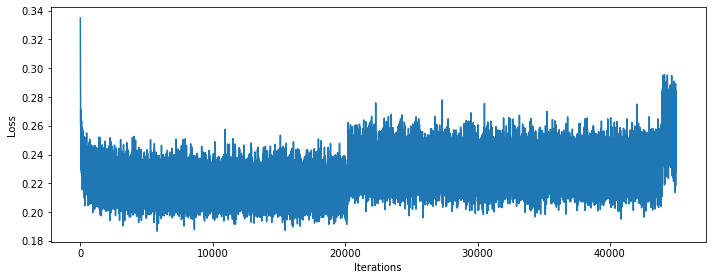

In [32]:
# DEFAULT EPSILON (1e-8)
fig, ax = plt.subplots(figsize=(10, 4))
# visualize the loss values
ax.plot(train_loss)
# set the labels
ax.set_ylabel('Loss')
ax.set_xlabel('Iterations')
fig.tight_layout()
plt.show()

In [33]:
optimizer.zero_grad()

In [34]:
PATH = '../../data/models/bert_emd_sasaki18.pth'

In [35]:
torch.save(model.state_dict(), PATH)